<a href="https://colab.research.google.com/github/visshal2301/AdvanceSpark_GoogleColab/blob/main/3_Partitioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [4]:
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "10g")
    .master("local[*]")
    .appName("6_0_partitioning")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [5]:
import psutil

ram = psutil.virtual_memory()
print("Total RAM (GB):", round(ram.total / (1024**3), 2))

Total RAM (GB): 12.67


In [6]:
listening_activity_file = "/content/drive/MyDrive/data/partitioning/raw/Spotify_Listening_Activity.csv"
df_listening_actv = spark.read.csv(listening_activity_file, header=True, inferSchema=True)
df_listening_actv.show(5, False)



+-----------+-------+--------------------------+---------------+
|activity_id|song_id|listen_date               |listen_duration|
+-----------+-------+--------------------------+---------------+
|1          |12     |2023-06-27 10:15:47.008867|69             |
|2          |44     |2023-06-27 10:15:47.008867|300            |
|3          |75     |2023-06-27 10:15:47.008867|73             |
|4          |48     |2023-06-27 10:15:47.008867|105            |
|5          |10     |2023-06-27 10:15:47.008867|229            |
+-----------+-------+--------------------------+---------------+
only showing top 5 rows



In [7]:
df_listening_actv = (
    df_listening_actv
    .withColumnRenamed("listen_date", "listen_time")
    .withColumn("listen_date", F.to_date("listen_time", "yyyy-MM-dd HH:mm:ss.SSSSSS"))
    .withColumn("listen_hour", F.hour("listen_time"))
)

df_listening_actv.show(5, False)
df_listening_actv.printSchema()
df_listening_actv.count()

+-----------+-------+--------------------------+---------------+-----------+-----------+
|activity_id|song_id|listen_time               |listen_duration|listen_date|listen_hour|
+-----------+-------+--------------------------+---------------+-----------+-----------+
|1          |12     |2023-06-27 10:15:47.008867|69             |2023-06-27 |10         |
|2          |44     |2023-06-27 10:15:47.008867|300            |2023-06-27 |10         |
|3          |75     |2023-06-27 10:15:47.008867|73             |2023-06-27 |10         |
|4          |48     |2023-06-27 10:15:47.008867|105            |2023-06-27 |10         |
|5          |10     |2023-06-27 10:15:47.008867|229            |2023-06-27 |10         |
+-----------+-------+--------------------------+---------------+-----------+-----------+
only showing top 5 rows

root
 |-- activity_id: integer (nullable = true)
 |-- song_id: integer (nullable = true)
 |-- listen_time: timestamp (nullable = true)
 |-- listen_duration: integer (nullable

11779

**Partitioning By listen_date**

Let's say we want to analyse the listening behaviours of user over time. If we're given the complete dataset (with no partitions), Spark would scan the whole dataset for finding a particular date (similar to the bookshelf analogy where you would scan the entire bookself for finding a book if it is not organized). Given that our usecase needs analysis by date, partitioning (creating folders) on date would help Spark pin point to the exact folder. This makes searching very easy and Spark doesn't scan the entire dataset.

In [9]:
(
    df_listening_actv
    .write
    .partitionBy("listen_date")
    .mode("overwrite")
    .parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt")
)

In [10]:
df_listening_actv_pt_pruned = spark.read.parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt")
df_listening_actv_pt_pruned.filter("listen_date = '2019-01-01'").explain()

== Physical Plan ==
*(1) ColumnarToRow
+- FileScan parquet [activity_id#125,song_id#126,listen_time#127,listen_duration#128,listen_hour#129,listen_date#130] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/drive/MyDrive/data/partitioning/partitioned/listening_ac..., PartitionFilters: [isnotnull(listen_date#130), (listen_date#130 = 2019-01-01)], PushedFilters: [], ReadSchema: struct<activity_id:int,song_id:int,listen_time:timestamp,listen_duration:int,listen_hour:int>




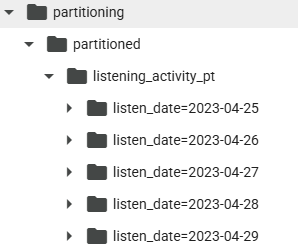

**Understanding the Physical Plan Snippet**

*(1) ColumnarToRow
This indicates that Spark is converting data from a columnar format (like Parquet's internal columnar storage) to a row-based format for further processing in the query. This often happens when the subsequent steps or the output require row-based data.

+- FileScan parquet [...]
This indicates that Spark is reading data from a Parquet file source.

The fields listed in brackets, like activity_id#125, song_id#126, etc., are the columns being read from the Parquet files.

Batched: true means that Spark is reading the data in columnar batches for efficiency before the ColumnarToRow conversion.

Location: InMemoryFileIndex(...) refers to where the input data files are located—in this case, on your Google Drive path /content/drive/MyDrive/data/partitioning/partitioned/listening_ac....

PartitionFilters: [isnotnull(listen_date#130), (listen_date#130 = 2019-01-01)] indicates partition pruning is applied—only partitions where the listen_date column is not null and equals 2019-01-01 are read, which is a big optimization to avoid scanning the entire dataset.

PushedFilters: [] means no additional data filters were pushed down to the Parquet reader beyond the partition filter.

ReadSchema: struct<activity_id:int,song_id:int,listen_time:timestamp,listen_duration:int,listen_hour:int> shows the schema (columns and data types) of the data being read after filtering.

**Why This Matters**

This plan shows an efficient scan over a partitioned Parquet dataset, where Spark is:

Pruning partitions based on the filter on listen_date for better performance.

Reading only the necessary columns.

Using columnar batch reads before converting to rows.

If you shared this physical plan to understand or debug shuffle partitions or resource use, note that:

This is a scan stage, so there's no shuffle happening here yet.

Shuffle partitions typically appear later, after transformations requiring data shuffling like joins, aggregations, or repartitions.

If You Want to Tune Shuffle or Memory
This physical plan step is before shuffle, so tuning parameters like spark.sql.shuffle.partitions won’t apply here.

You can further optimize by ensuring partition pruning filters are pushed down, which seems to be happening.

Monitor the DAG and subsequent stages for shuffle to tune partitions effectively.

If you'd like, I can help you interpret the full physical plan or explain the next steps in the query execution related to shuffle partitions or resource tuning. Just share more context or the entire plan!

**Partitioning Examples**

Single/multi level partitioning
Using repartition/coalesce with partitionBy (controlling number of files inside each partition):

parititionBy affects how data is laid out in the storage and is going to ensure that the output directory is organized into subdirectories based on the value given in partitionBy.
Number of files in each value directory of partitionBy depends on the number supplied in the repartition/coalesce.


**1. Single/multi level partitioning**

In [11]:
(
    df_listening_actv
    .write
    .mode("overwrite")
    .partitionBy("listen_date", "listen_hour")
    .parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt_2")
)

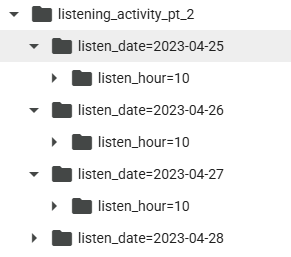

In [13]:
(
    df_listening_actv
    .write
    .mode("overwrite")
    .partitionBy("listen_hour", "listen_date")
    .parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt_3")
)

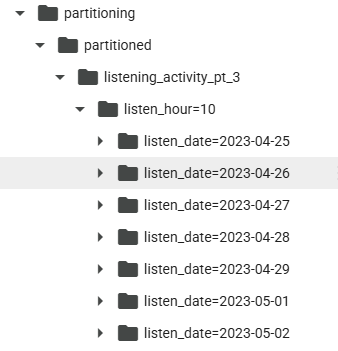

**2. Using repartition/coalesce with partitionBy**

In [15]:
(
    df_listening_actv
    .repartition(3)
    .write
    .mode("overwrite")
    .partitionBy("listen_date")
    .parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt_4")
)

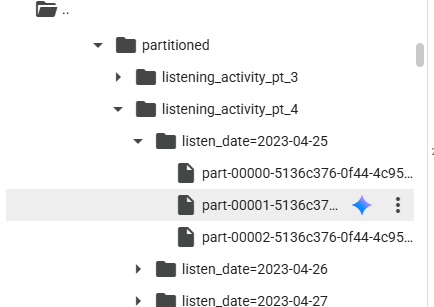

In [17]:
# The coalesce method reduces the number of partitions in a DataFrame.
# It avoids full shuffle, instead of creating new partitions, it shuffles the data using default Hash Partitioner,
# and adjusts into existing partitions, this means it can only decrease the number of partitions.

(
    df_listening_actv
    .coalesce(3)
    .write
    .mode("overwrite")
    .partitionBy("listen_date")
    .parquet("/content/drive/MyDrive/data/partitioning/partitioned/listening_activity_pt_5")
)

**Experimenting With spark.sql.files.maxPartitionBytes**

In [19]:
spark.stop()
spark = SparkSession.builder.appName("Test spark.sql.files.maxPartitionBytes").getOrCreate()

df_default = spark.read.csv("/content/drive/MyDrive/data/partitioning/raw/Spotify_Listening_Activity.csv", header=True, inferSchema=True)
default_partitions = df_default.rdd.getNumPartitions()
print(f"Number of partitions with default maxPartitionBytes: {default_partitions}")

Number of partitions with default maxPartitionBytes: 1


In [20]:
spark.conf.set("spark.sql.files.maxPartitionBytes", "1000")

df_modified = spark.read.csv("/content/drive/MyDrive/data/partitioning/raw/Spotify_Listening_Activity.csv", header=True, inferSchema=True)
modified_partitions = df_modified.rdd.getNumPartitions()
print(f"Number of partitions with modified maxPartitionBytes: {modified_partitions}")

Number of partitions with modified maxPartitionBytes: 468
